In [43]:
# Preparing the basics... Import required modules

%matplotlib inline
from   matplotlib             import style
import matplotlib.pyplot      as     plt
import numpy                  as     np
import sqlalchemy
from   sqlalchemy.ext.automap import automap_base
from   sqlalchemy.orm         import Session
from   sqlalchemy             import create_engine, func
from   sqlalchemy.inspection  import inspect
from   collections            import defaultdict
import datetime               as     dt
import pandas                 as     pd

In [44]:
# Creating a auxiliary function to translate a query result set into a pandas dataframe

def query_to_dict(rset):
    result = defaultdict(list)
    for obj in rset:
        instance = inspect(obj)
        for key, x in instance.attrs.items():
            result[key].append(x.value)
    return result

In [45]:
# create engine to hawaii.sqlite

engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [46]:
# reflect an existing database into a new model

Base = automap_base()
Base.prepare(autoload_with=engine)
Base.classes.keys()

# reflect the tables

Tables = Base.classes.keys()

In [47]:
# View all of the classes that automap found

print(f"There are {len(Tables)} tables in this database")
print(f"First is {Tables[0]}")
print(f"Next  is {Tables[1]}")

There are 2 tables in this database
First is measurement
Next  is station


In [48]:
# Save references to each table
measurement = Base.classes.measurement
station     = Base.classes.station
print(f"The reference for the first tab is {measurement}")
print(f"The reference for the next  tab is {station}")

The reference for the first tab is <class 'sqlalchemy.ext.automap.measurement'>
The reference for the next  tab is <class 'sqlalchemy.ext.automap.station'>


In [49]:
# Create our session (link) from Python to the DB

session = Session(engine)

In [50]:
# Exploratory Precipitation Analysis
#
# 1.1 
#
# Find the most recent date in the data set.
# Query retuns the highest value for date in the table measurement, as the order is descending

max_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
print(f"The most recent entry: {max_date.date}")

The most recent entry: 2017-08-23


Query upper limit is 2017-08-23 00:00:00
Query lower limit is 2016-08-22 00:00:00


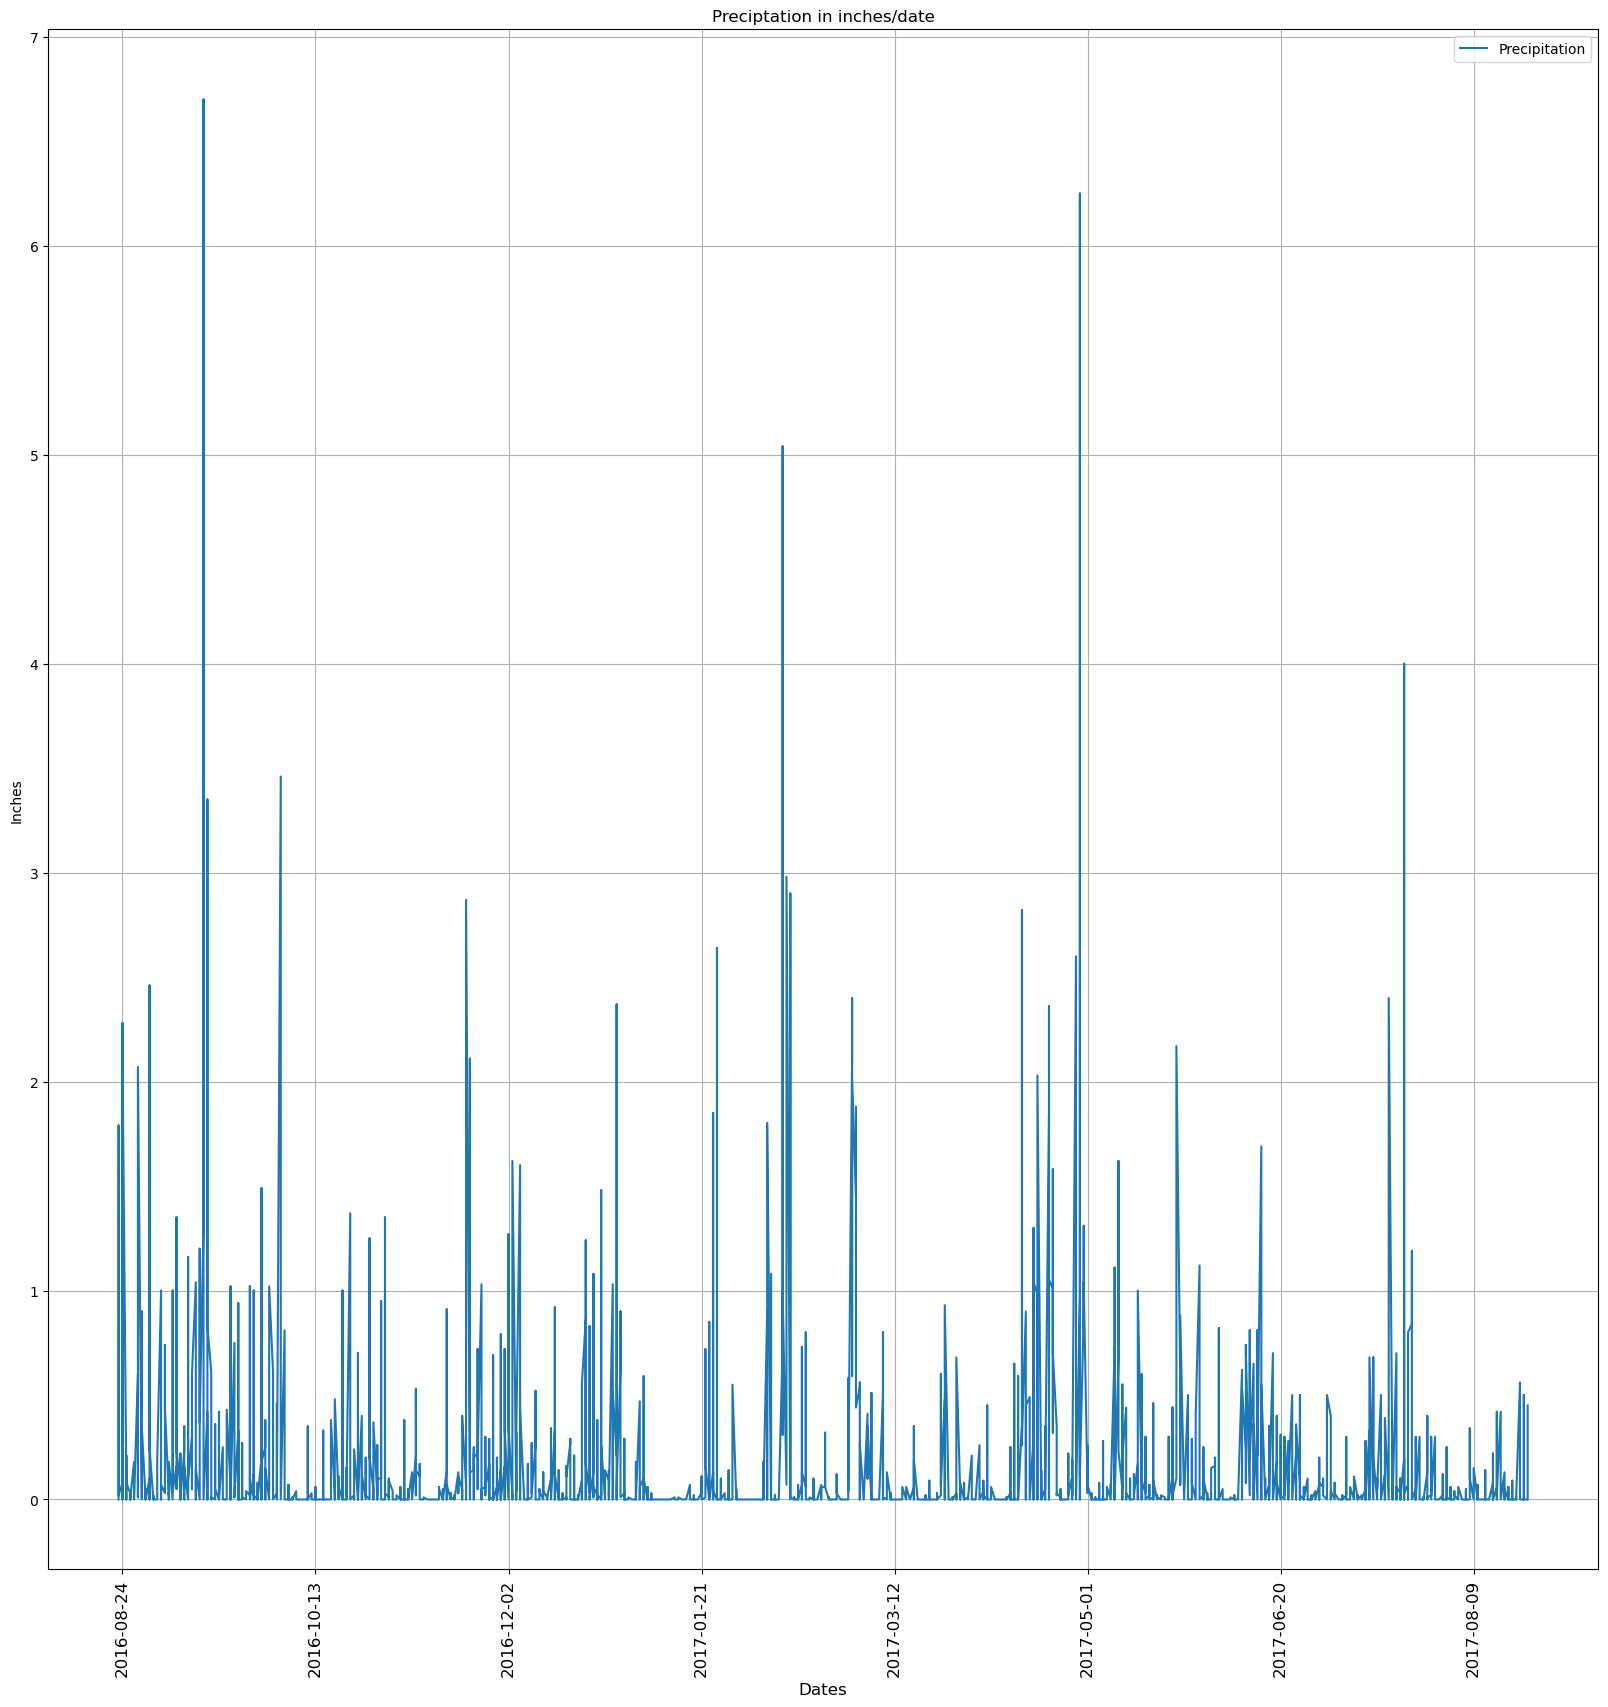

<Axes: title={'center': 'Preciptation in inches/date'}, xlabel='Date', ylabel='inches'>

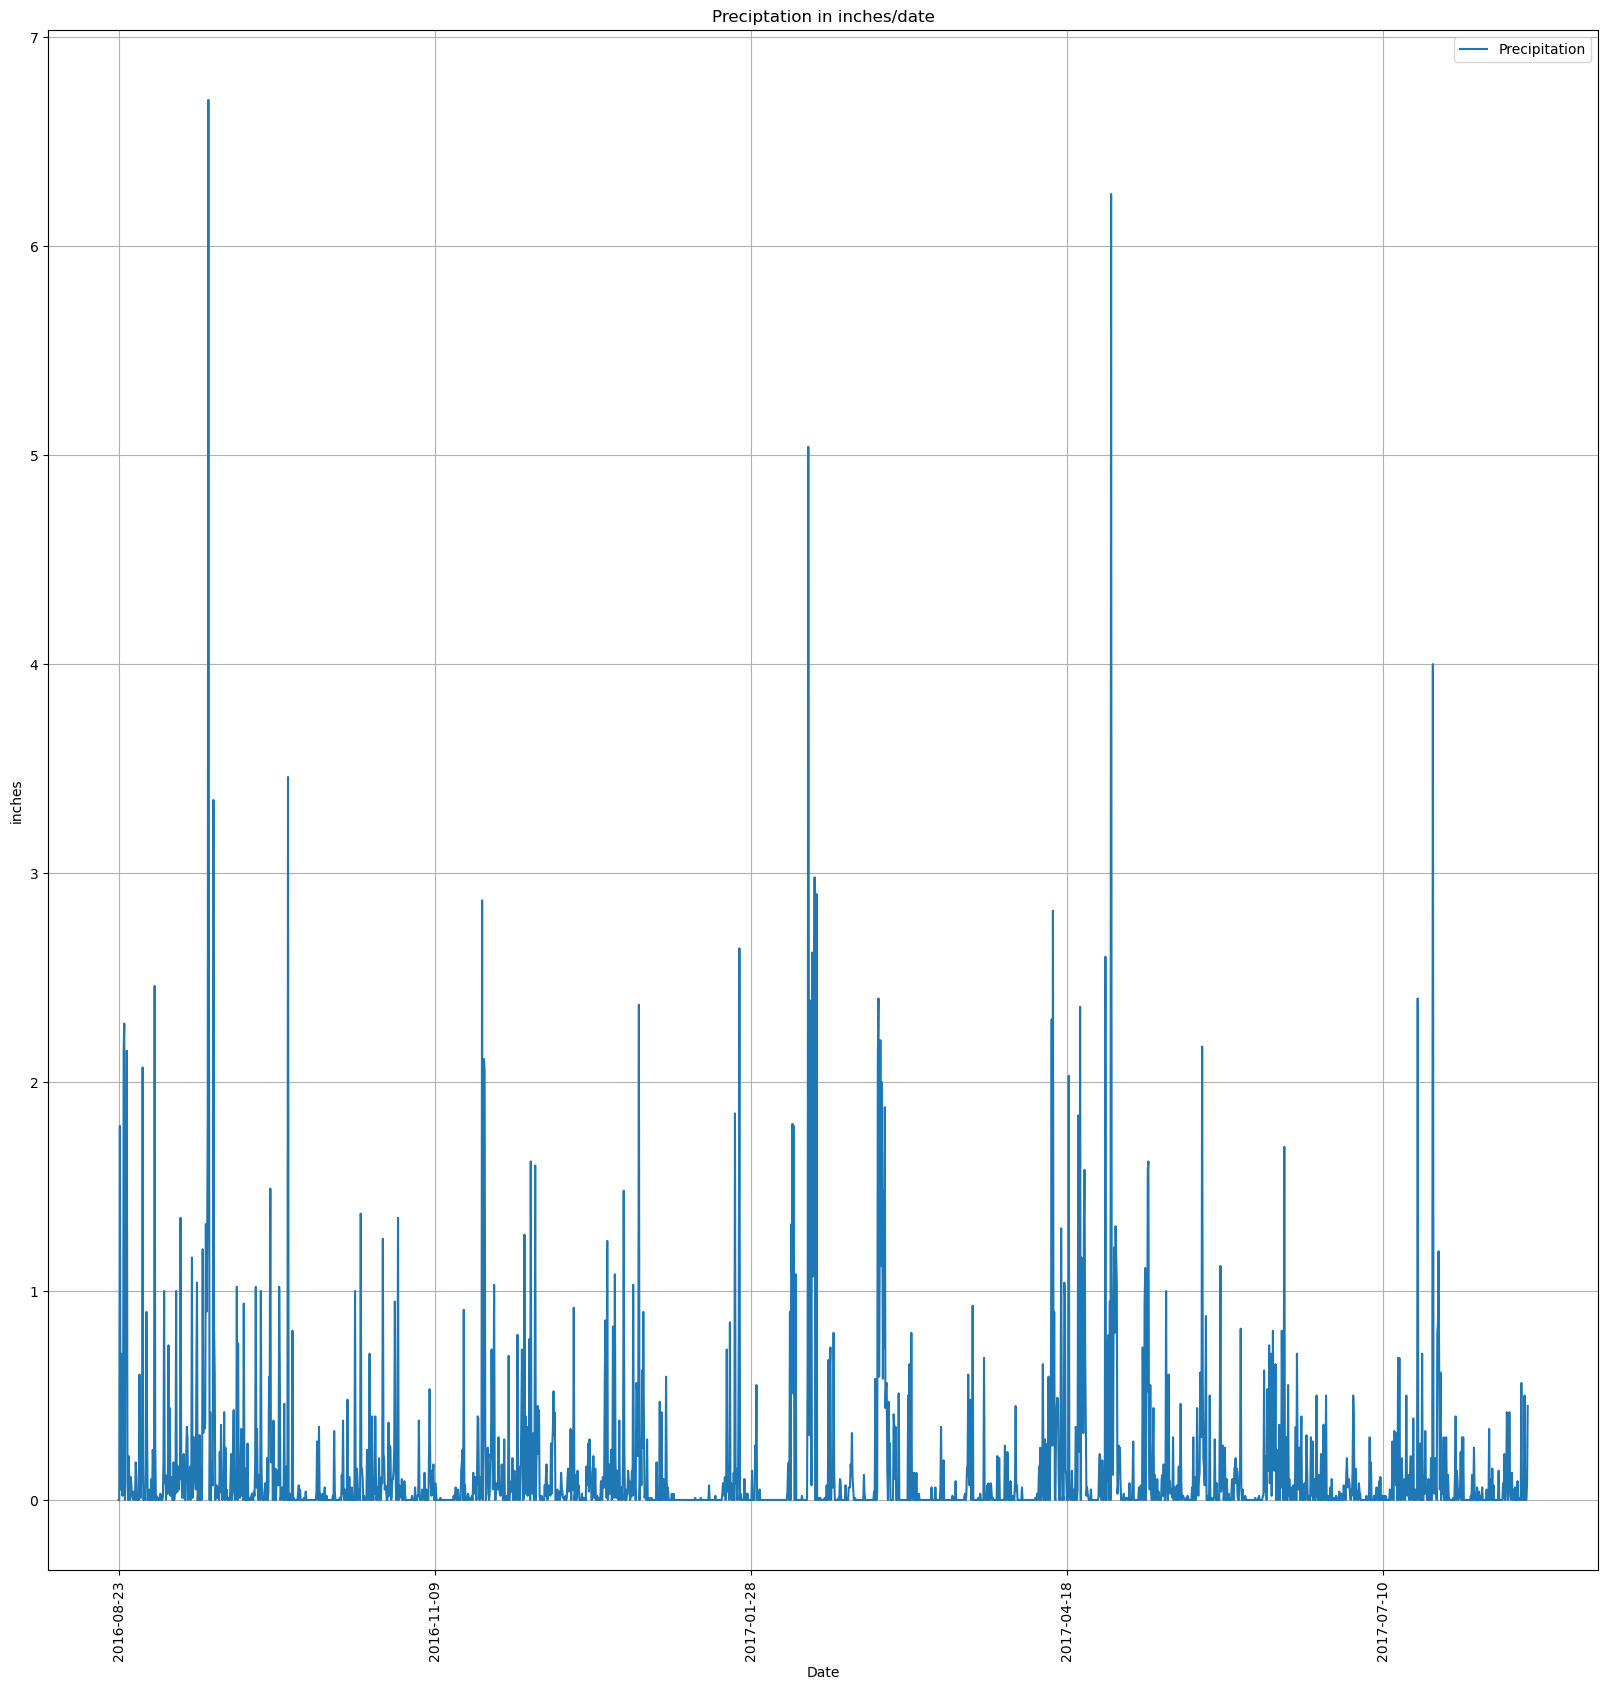

In [67]:
#
# 1.2 thru 1.6
#
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame. Explicitly set the column names
# Sort the dataframe by date
# Use Pandas Plotting with Matplotlib to plot the data

# Calculating date limits

High_date = dt.datetime.strptime(max_date.date, "%Y-%m-%d")
Low_date = High_date - dt.timedelta(days=366) 
print(F"Query upper limit is {High_date}")
print(F"Query lower limit is {Low_date}")

# Retrieve the data and store it in a DataFrame

Query12Month    = session.query(measurement).filter(measurement.date <= High_date).filter(measurement.date >= Low_date)
Query12MonthDF = pd.DataFrame(query_to_dict(Query12Month))
Query12MonthDF = Query12MonthDF.replace(np. nan,0)
Query12MonthDF = Query12MonthDF.sort_values(by=['date'],ascending = True)
Query12MonthDF = Query12MonthDF.rename(columns={"date": "Date", "prcp": "Precipitation"})
del Query12MonthDF['id']
del Query12MonthDF['station']
del Query12MonthDF['tobs']

# Work the Graph, labels, legend, etc.
# Graphic option 1 - Matplotlib
plt.figure(figsize=(20,20))
plt.plot(Query12MonthDF.Date,Query12MonthDF.Precipitation,label='Precipitation')
plt.legend()
plt.grid()
plt.xlabel('Dates',fontsize=12)
plt.xticks(rotation = 90,fontsize=12)
plt.xticks(np.arange(1, Query12MonthDF.Date.count(), 50))
plt.ylabel('Inches')
plt.title('Preciptation in inches/date')
plt.locator_params(axis='x', nbins=50)
plt.show()

# Query12MonthDF.head()
# Work the Graph, labels, legend, etc.
# Graphic option 2 - Pandas

Query12MonthDF.plot(figsize=(20,20),grid=True,x='Date',y='Precipitation',ylabel='inches', rot=90,title='Preciptation in inches/date')

# Showing both techniques to get an appreciation of ease of use, complexity, etc.

In [52]:
#
# 1.7
#
# Use Pandas to calculate the summary statistics for the precipitation data

print('Stat Summary for Precipitation')
print('==============================')
Q12Summ = pd.DataFrame(Query12MonthDF.Precipitation.describe())
Q12Summ


Stat Summary for Precipitation


,Precipitation
count,2230.000000
mean,0.160664
std,0.442067
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,6.700000


# Exploratory Station Analysis

In [53]:
#
# 2.1
#
# Design a query to calculate the total number of stations in the dataset
Stations        = session.query(station).count()
print(f"There are {Stations} Stations in the database")

There are 9 Stations in the database


In [54]:
#
# 2.2
#  
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
countStation = session.query(measurement.station,\
                             func.count(measurement.station).label("countstation")).\
                             group_by(measurement.station).\
                             order_by(func.count(measurement.station).desc())

for line in countStation:
    print(F"Station : {line.station} Instance count: {line.countstation}")

Station : USC00519281 Instance count: 2772
Station : USC00519397 Instance count: 2724
Station : USC00513117 Instance count: 2709
Station : USC00519523 Instance count: 2669
Station : USC00516128 Instance count: 2612
Station : USC00514830 Instance count: 2202
Station : USC00511918 Instance count: 1979
Station : USC00517948 Instance count: 1372
Station : USC00518838 Instance count: 511


In [55]:
# 
# 2.3
#
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
FirstStation = countStation.first().station
print(F"The most frequent station : {FirstStation}")

QueryStation  = session.query(measurement.station, \
                              func.max(measurement.tobs).label("maxtemp"), \
                              func.min(measurement.tobs).label("mintemp"),
                              func.avg(measurement.tobs).label("avgtemp")). \
                              filter(measurement.station == FirstStation)
for line in QueryStation:
    print(F"Station : {line.station} mintemp: {line.mintemp} maxtemp: {line.maxtemp} avgtemp : {line.avgtemp}")

#print(QueryStation.statement)
#print(QueryStation.maxtemp)
#print(QueryStation.mintemp)

The most frequent station : USC00519281
Station : USC00519281 mintemp: 54.0 maxtemp: 85.0 avgtemp : 71.66378066378067


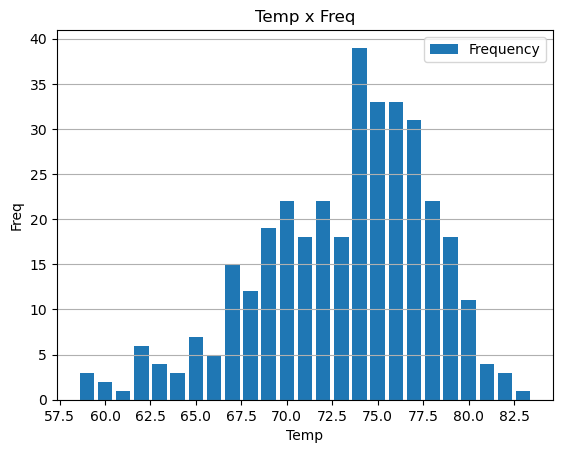

In [56]:
# 
# 2.4
#
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
Query12MonthTemp = session.query(measurement.tobs.label("Temperature"), \
                                 func.count(measurement.tobs).label("Frequency")). \
                                 filter(measurement.date <= High_date).\
                                 filter(measurement.date >= Low_date).\
                                 filter(measurement.station == FirstStation).\
                                 group_by(measurement.tobs)
Temperature = []
Frequency = []
for line in Query12MonthTemp:
    Temperature.append(line.Temperature)
    Frequency.append(line.Frequency)
    
plt.bar(Temperature,Frequency,label='Frequency')
plt.legend()
plt.grid(axis = 'y')
plt.xlabel('Temp')
plt.ylabel('Freq')
plt.title('Temp x Freq')
plt.locator_params(axis='x', nbins=12)
plt.show()

# Close Session

In [57]:
# Close Session
session.close()